In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('TSLA.csv')

# Convert 'Date' to datetime and sort
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)

# Set 'Date' as index
df.set_index('Date', inplace=True)

# Preview the dataset
print(df.head())


                 Open   High        Low      Close  Adj Close    Volume
Date                                                                   
2010-06-29  19.000000  25.00  17.540001  23.889999  23.889999  18766300
2010-06-30  25.790001  30.42  23.299999  23.830000  23.830000  17187100
2010-07-01  25.000000  25.92  20.270000  21.959999  21.959999   8218800
2010-07-02  23.000000  23.10  18.709999  19.200001  19.200001   5139800
2010-07-06  20.000000  20.00  15.830000  16.110001  16.110001   6866900


Missing values:
 Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


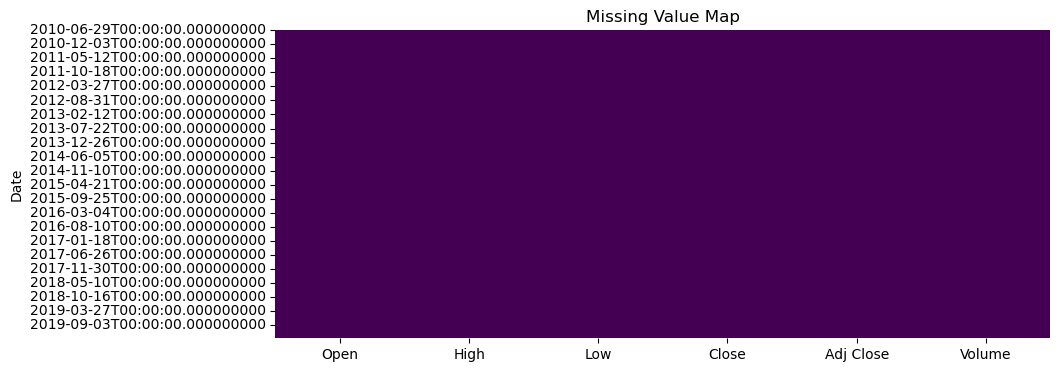

In [11]:
# Check for missing values
missing = df.isnull().sum()
print("Missing values:\n", missing)

# Visualize missing values
plt.figure(figsize=(10, 4))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Value Map")
plt.show()


In [12]:
# Option 1: Forward Fill
df_ffill = df.fillna(method='ffill')

# Option 2: Backward Fill
df_bfill = df.fillna(method='bfill')

# Option 3: Linear Interpolation (best for prices)
df_interp = df.interpolate(method='linear')


C:\Users\Vishal\AppData\Local\Temp\ipykernel_13524\1247831865.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_ffill = df.fillna(method='ffill')
C:\Users\Vishal\AppData\Local\Temp\ipykernel_13524\1247831865.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_bfill = df.fillna(method='bfill')


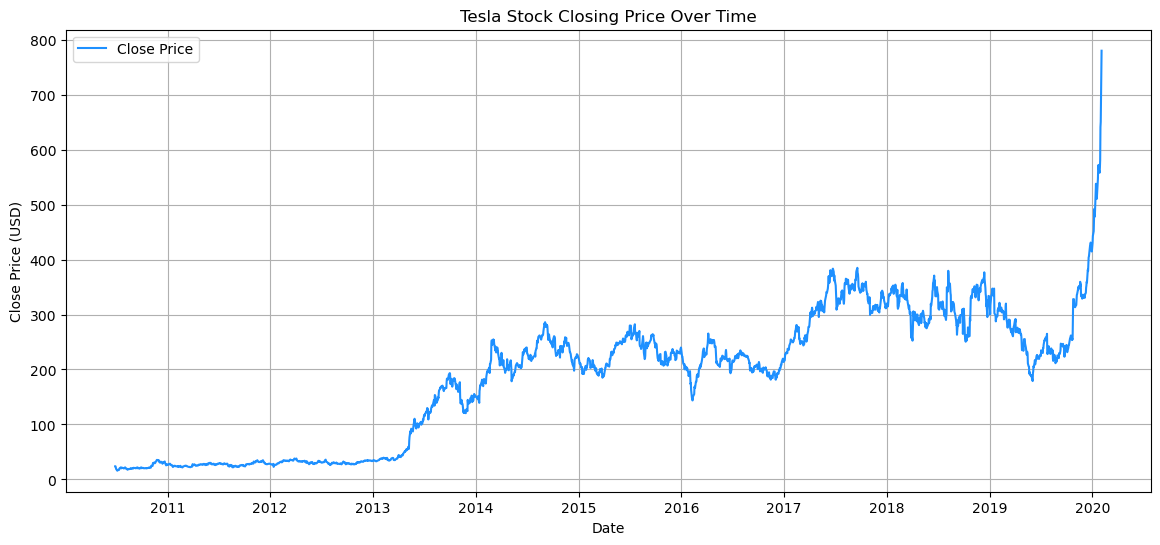

In [13]:
# Plot Closing Price over time
plt.figure(figsize=(14, 6))
plt.plot(df_interp['Close'], label='Close Price', color='dodgerblue')
plt.title('Tesla Stock Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


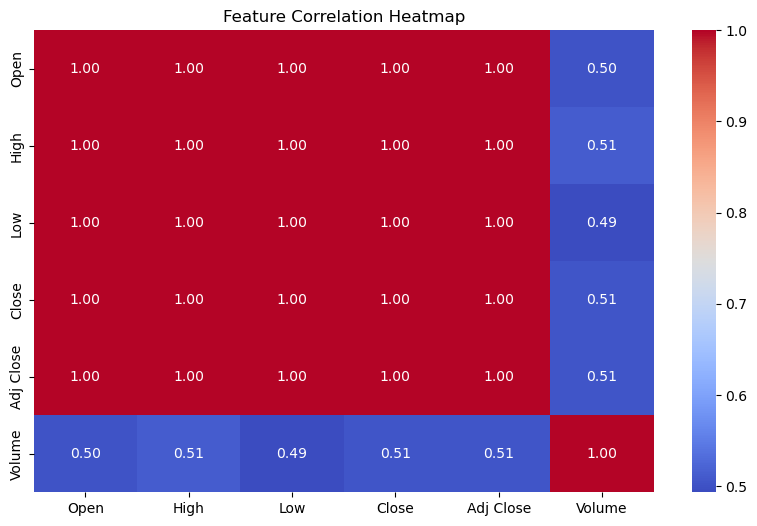

In [14]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_interp.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.show()


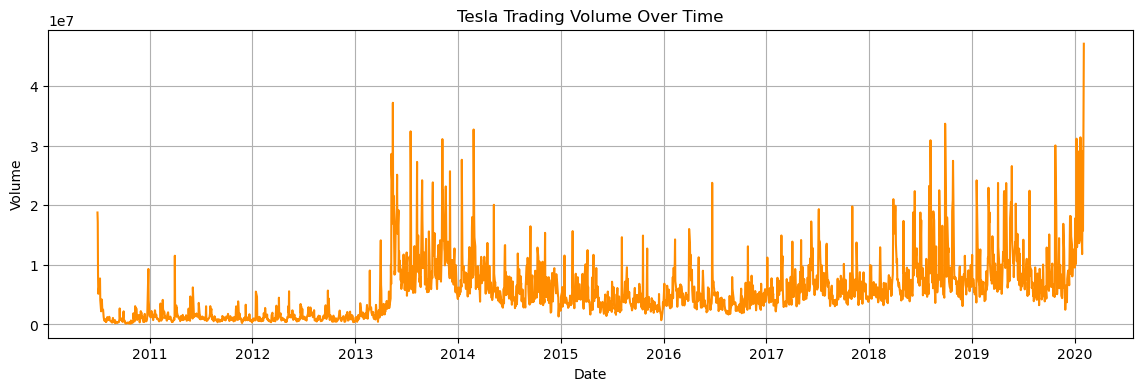

In [16]:
plt.figure(figsize=(14, 4))
plt.plot(df_interp['Volume'], color='darkorange')
plt.title('Tesla Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.grid(True)
plt.show()


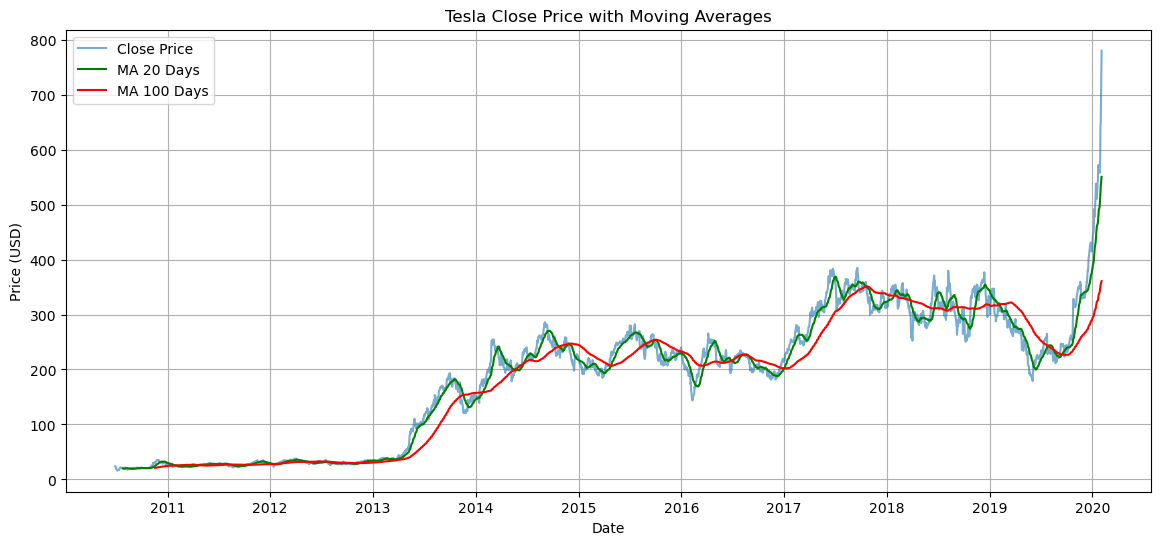

In [17]:
# Add 20-day and 100-day moving averages
df_interp['MA20'] = df_interp['Close'].rolling(window=20).mean()
df_interp['MA100'] = df_interp['Close'].rolling(window=100).mean()

# Plot
plt.figure(figsize=(14, 6))
plt.plot(df_interp['Close'], label='Close Price', alpha=0.6)
plt.plot(df_interp['MA20'], label='MA 20 Days', color='green')
plt.plot(df_interp['MA100'], label='MA 100 Days', color='red')
plt.title('Tesla Close Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


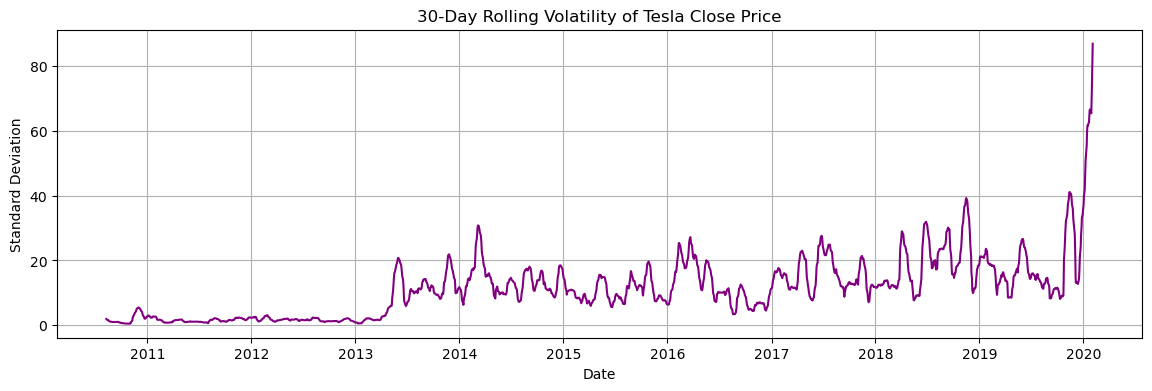

In [18]:
# 30-day rolling standard deviation
df_interp['Volatility'] = df_interp['Close'].rolling(window=30).std()

plt.figure(figsize=(14, 4))
plt.plot(df_interp['Volatility'], color='purple')
plt.title('30-Day Rolling Volatility of Tesla Close Price')
plt.xlabel('Date')
plt.ylabel('Standard Deviation')
plt.grid(True)
plt.show()


In [19]:
from sklearn.preprocessing import MinMaxScaler

# Use only Close column for training (can add more later)
scaler = MinMaxScaler(feature_range=(0, 1))
df_interp['Close_Scaled'] = scaler.fit_transform(df_interp[['Close']])

# Preview
print(df_interp[['Close', 'Close_Scaled']].head())


                Close  Close_Scaled
Date                               
2010-06-29  23.889999      0.010586
2010-06-30  23.830000      0.010508
2010-07-01  21.959999      0.008061
2010-07-02  19.200001      0.004449
2010-07-06  16.110001      0.000406


In [20]:
import numpy as np

def create_sequences(data, window_size=60, horizons=[1, 5, 10]):
    X, y1, y5, y10 = [], [], [], []

    for i in range(len(data) - window_size - max(horizons)):
        seq_x = data[i:i + window_size]
        X.append(seq_x)

        y1.append(data[i + window_size + 1 - 1])   # 1-day ahead
        y5.append(data[i + window_size + 5 - 1])   # 5-day ahead
        y10.append(data[i + window_size + 10 - 1]) # 10-day ahead

    return np.array(X), np.array(y1), np.array(y5), np.array(y10)


In [21]:
# Only use the scaled Close column
close_scaled = df_interp['Close_Scaled'].values

# Create sequences
X, y1, y5, y10 = create_sequences(close_scaled, window_size=60)


In [22]:
print(f"X shape: {X.shape}")       # (samples, 60)
print(f"y1 shape: {y1.shape}")     # (samples,)
print(f"y5 shape: {y5.shape}")     # (samples,)
print(f"y10 shape: {y10.shape}")   # (samples,)


X shape: (2346, 60)
y1 shape: (2346,)
y5 shape: (2346,)
y10 shape: (2346,)


In [23]:
# Reshape X to 3D for LSTM: (samples, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))


In [24]:
split_idx = int(0.8 * len(X))

X_train, X_test = X[:split_idx], X[split_idx:]
y1_train, y1_test = y1[:split_idx], y1[split_idx:]
y5_train, y5_test = y5[:split_idx], y5[split_idx:]
y10_train, y10_test = y10[:split_idx], y10[split_idx:]

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")


Training samples: 1876
Testing samples: 470


In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [26]:
def build_rnn(units=50, dropout=0.2, lr=0.001, window=60):
    model = Sequential([
        SimpleRNN(units, input_shape=(window, 1)),
        Dropout(dropout),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
    return model

def build_lstm(units=50, dropout=0.2, lr=0.001, window=60):
    model = Sequential([
        LSTM(units, input_shape=(window, 1)),
        Dropout(dropout),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
    return model


In [27]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

checkpoint_rnn = ModelCheckpoint('best_rnn_model.h5', save_best_only=True, monitor='val_loss')
checkpoint_lstm = ModelCheckpoint('best_lstm_model.h5', save_best_only=True, monitor='val_loss')


In [28]:
# Build models
rnn_model = build_rnn(window=60)
lstm_model = build_lstm(window=60)

# Train SimpleRNN
history_rnn = rnn_model.fit(
    X_train, y1_train,
    validation_data=(X_test, y1_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, checkpoint_rnn],
    verbose=1
)

# Train LSTM
history_lstm = lstm_model.fit(
    X_train, y1_train,
    validation_data=(X_test, y1_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, checkpoint_lstm],
    verbose=1
)


c:\Users\Vishal\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
55/59 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0223

59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - loss: 0.0211 - val_loss: 0.0021
Epoch 2/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0014

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 3/100
55/59 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0011

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 4/100
56/59 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.6213e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 8.6521e-04 - val_loss: 8.7332e-04
Epoch 5/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.2188e-04 - val_loss: 9.3072e-04
Epoch 6/100
56/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.1285e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 8.1180e-04 - val_loss: 7.6522e-04
Epoch 7/100
56/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.3105e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.3164e-04 - val_loss: 6.5319e-04
Epoch 8/100
54/59 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.4192e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 8.3163e-04 - val_loss: 4.9342e-04
Epoch 9/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.1566e-04 - val_loss: 5.1968e-04
Epoch 10/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.3825e-04 - val_loss: 5.6550e-04
Epoch 11/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.5396e-04 - val_loss: 7.2959e-04
Epoch 12/100
54/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.4650e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.4470e-04 - val_loss: 4.7145e-04
Epoch 13/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.9861e-04 - val_loss: 5.8736e-04
Epoch 14/100
54/59 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.5839e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.6051e-04 - val_loss: 4.6989e-04
Epoch 15/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.1658e-04 - val_loss: 7.5389e-04
Epoch 16/100
56/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4919e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.4891e-04 - val_loss: 3.7015e-04
Epoch 17/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.1334e-04 - val_loss: 3.7446e-04
Epoch 18/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.1800e-04 - val_loss: 4.0521e-04
Epoch 19/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.7710e-04 - val_loss: 4.3767e-04
Epoch 20/100
56/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.9053e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.9073e-04 - val_loss: 3.3692e-04
Epoch 21/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.1835e-04 - val_loss: 4.7032e-04
Epoch 22/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.7976e-04 - val_loss: 3.5817e-04
Epoch 23/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.6240e-04 - val_loss: 3.8916e-04
Epoch 24/100
56/59 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.5131e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.5052e-04 - val_loss: 3.1052e-04
Epoch 25/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.2090e-04 - val_loss: 3.4006e-04
Epoch 26/100
58/59 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.9823e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.9860e-04 - val_loss: 2.9984e-04
Epoch 27/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.3296e-04 - val_loss: 3.2565e-04
Epoch 28/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.1058e-04 - val_loss: 4.2259e-04
Epoch 29/100
54/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.0311e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.0303e-04 - val_loss: 2.8335e-04
Epoch 30/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.5147e-04 - val_loss: 4.7661e-04
Epoch 31/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.2029e-04 - val_loss: 2.8368e-04
Epoch 32/100
54/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.6547e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.6633e-04 - val_loss: 2.7767e-04
Epoch 33/100
53/59 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.8336e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.8326e-04 - val_loss: 2.7019e-04
Epoch 34/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.4425e-04 - val_loss: 2.7290e-04
Epoch 35/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.8635e-04 - val_loss: 2.7990e-04
Epoch 36/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.4376e-04 - val_loss: 3.1766e-04
Epoch 37/100
53/59 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.0949e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.0839e-04 - val_loss: 2.6654e-04
Epoch 38/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.2939e-04 - val_loss: 3.4597e-04
Epoch 39/100
54/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.5833e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.5651e-04 - val_loss: 2.6168e-04
Epoch 40/100
58/59 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.3840e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.3843e-04 - val_loss: 2.5799e-04
Epoch 41/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.2455e-04 - val_loss: 2.9775e-04
Epoch 42/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.4142e-04 - val_loss: 3.4461e-04
Epoch 43/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.4611e-04 - val_loss: 3.0156e-04
Epoch 44/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.2674e-04 - val_loss: 3.4371e-04
Epoch 45/100
57/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.6959e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.6891e-04 - val_loss: 2.4235e-04
Epoch 46/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.3284e-04 - val_loss: 2.7681e-04
Epoch 47/100
53/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.2097e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.2110e-04 - val_loss: 2.3949e-04
Epoch 48/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.0316e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.0340e-04 - val_loss: 2.3804e-04
Epoch 49/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.1702e-04 - val_loss: 3.3670e-04
Epoch 50/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.7862e-04 - val_loss: 2.6475e-04
Epoch 51/100
56/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.1604e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.1576e-04 - val_loss: 2.3394e-04
Epoch 52/100
57/59 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.0347e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.0345e-04 - val_loss: 2.3163e-04
Epoch 53/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.8706e-04 - val_loss: 2.4613e-04
Epoch 54/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.2722e-04 - val_loss: 2.7017e-04
Epoch 55/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.0798e-04 - val_loss: 2.7544e-04
Epoch 56/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.0031e-04 - val_loss: 3.2128e-04
Epoch 57/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.0596e-04 - val_loss: 2.3663e-04
Epoch 58/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.1576e-04 - val_loss: 2.3542e-04
Epoch 59/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.0692e-04 - val_loss: 2.5850e-04
Epoch 60/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.9857e-04 - val_loss: 2.3566e-04
Epoch 61/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.0160e-04 - val_loss: 2.4015e-04
Epoch 62/100
55/59 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.0

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.0396e-04 - val_loss: 2.1552e-04
Epoch 63/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.9687e-04 - val_loss: 2.4282e-04
Epoch 64/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.9746e-04 - val_loss: 2.1784e-04
Epoch 65/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.0157e-04 - val_loss: 2.2278e-04
Epoch 66/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.7919e-04 - val_loss: 2.7321e-04
Epoch 67/100
58/59 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.0321e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 2.0324e-04 - val_loss: 2.1505e-04
Epoch 68/100
57/59 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9066e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.9118e-04 - val_loss: 2.1352e-04
Epoch 69/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.8603e-04 - val_loss: 2.1355e-04
Epoch 70/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.6936e-04 - val_loss: 2.6516e-04
Epoch 71/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.9975e-04 - val_loss: 2.1392e-04
Epoch 72/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.8566e-04 - val_loss: 2.1668e-04
Epoch 73/100
56/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.8132e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.8136e-04 - val_loss: 2.0762e-04
Epoch 74/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.8964e-04 - val_loss: 2.1938e-04
Epoch 75/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.7884e-04 - val_loss: 2.1495e-04
Epoch 76/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.6462e-04 - val_loss: 2.1585e-04
Epoch 77/100
54/59 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.7554e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.7484e-04 - val_loss: 2.0407e-04
Epoch 78/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.7920e-04 - val_loss: 2.0805e-04
Epoch 79/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7506e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7508e-04 - val_loss: 2.0391e-04
Epoch 80/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.0444e-04 - val_loss: 2.0638e-04
Epoch 81/100
56/59 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.8689e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.8729e-04 - val_loss: 2.0198e-04
Epoch 82/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.7745e-04 - val_loss: 2.0365e-04
Epoch 83/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.8048e-04 - val_loss: 2.1346e-04
Epoch 84/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.6403e-04 - val_loss: 2.1393e-04
Epoch 85/100
55/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.4502e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.4615e-04 - val_loss: 2.0009e-04
Epoch 86/100
53/59 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.5722e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.5860e-04 - val_loss: 1.9891e-04
Epoch 87/100
56/59 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7728e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.7753e-04 - val_loss: 1.9821e-04
Epoch 88/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.6568e-04 - val_loss: 2.0331e-04
Epoch 89/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.6385e-04 - val_loss: 2.4733e-04
Epoch 90/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6907e-04 - val_loss: 2.0419e-04
Epoch 91/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.7867e-04 - val_loss: 1.9871e-04
Epoch 92/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.7820e-04 - val_loss: 2.4498e-04
Epoch 93/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.7775e-04 - val_loss: 1.9870e-04
Epoch 94/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.6303e-04 - val_loss: 1.9830e-04
Epoch 95/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7175e-04 - val_loss: 2.0325e-04
Epoch 96/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.5459e-04 - val_loss: 2.0223e-04
Epoch 97/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.

59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0157 - val_loss: 9.7860e-04
Epoch 2/100
58/59 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 8.7177e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 8.6976e-04 - val_loss: 7.8449e-04
Epoch 3/100
58/59 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 7.3940e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 7.3800e-04 - val_loss: 7.5922e-04
Epoch 4/100
57/59 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 6.6112e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 6.5900e-04 - val_loss: 7.0589e-04
Epoch 5/100
57/59 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 5.3641e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 5.3689e-04 - val_loss: 6.9887e-04
Epoch 6/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4.3960e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 4.4028e-04 - val_loss: 6.7567e-04
Epoch 7/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 5.0526e-04 - val_loss: 6.9842e-04
Epoch 8/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 4.6029e-04 - val_loss: 8.5063e-04
Epoch 9/100
58/59 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.3515e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 4.3586e-04 - val_loss: 6.5637e-04
Epoch 10/100
57/59 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 4.2456e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 4.2427e-04 - val_loss: 6.2069e-04
Epoch 11/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.2375e-04 - val_loss: 6.9070e-04
Epoch 12/100
57/59 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4.3530e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 4.3524e-04 - val_loss: 5.8056e-04
Epoch 13/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 4.0062e-04 - val_loss: 8.6963e-04
Epoch 14/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 3.8506e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 3.8505e-04 - val_loss: 5.7691e-04
Epoch 15/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.0928e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 4.0903e-04 - val_loss: 5.5905e-04
Epoch 16/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.7129e-04 - val_loss: 6.9570e-04
Epoch 17/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 3.9868e-04 - val_loss: 5.5950e-04
Epoch 18/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.3249e-04 - val_loss: 5.8535e-04
Epoch 19/100
57/59 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.6051e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 3.6082e-04 - val_loss: 5.0237e-04
Epoch 20/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 3.5216e-04 - val_loss: 5.0438e-04
Epoch 21/100
58/59 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 3.2700e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 3.2721e-04 - val_loss: 4.9680e-04
Epoch 22/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 3.0018e-04 - val_loss: 5.2577e-04
Epoch 23/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 3.0139e-04 - val_loss: 5.5573e-04
Epoch 24/100
58/59 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.4083e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 3.3984e-04 - val_loss: 4.6359e-04
Epoch 25/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 2.9978e-04 - val_loss: 4.8440e-04
Epoch 26/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2.6852e-04 - val_loss: 4.8748e-04
Epoch 27/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 2.9299e-04 - val_loss: 4.6793e-04
Epoch 28/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 3.4280e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 3.4230e-04 - val_loss: 4.3999e-04
Epoch 29/100
58/59 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.9923e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 2.9855e-04 - val_loss: 4.3798e-04
Epoch 30/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 2.7158e-04 - val_loss: 6.3775e-04
Epoch 31/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 2.5555e-04 - val_loss: 5.4014e-04
Epoch 32/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 2.6236e-04 - val_loss: 4.5720e-04
Epoch 33/100
58/59 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2.4759e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 2.4789e-04 - val_loss: 4.2467e-04
Epoch 34/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 2.5196e-04 - val_loss: 4.2480e-04
Epoch 35/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 2.3398e-04 - val_loss: 5.2033e-04
Epoch 36/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 2.2738e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 2.2741e-04 - val_loss: 4.1225e-04
Epoch 37/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 2.3652e-04 - val_loss: 4.1732e-04
Epoch 38/100
58/59 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2.2148e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 2.2134e-04 - val_loss: 3.9845e-04
Epoch 39/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 2.5842e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 2.5817e-04 - val_loss: 3.8416e-04
Epoch 40/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 2.6116e-04 - val_loss: 4.4715e-04
Epoch 41/100
57/59 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.3736e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2.3757e-04 - val_loss: 3.7628e-04
Epoch 42/100
58/59 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2.3246e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 2.3229e-04 - val_loss: 3.7070e-04
Epoch 43/100
57/59 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.0979e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2.1011e-04 - val_loss: 3.6675e-04
Epoch 44/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2.1912e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 2.1913e-04 - val_loss: 3.6472e-04
Epoch 45/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.9551e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 1.9580e-04 - val_loss: 3.5745e-04
Epoch 46/100
58/59 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.1417e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2.1432e-04 - val_loss: 3.5630e-04
Epoch 47/100
57/59 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2.3727e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 2.3696e-04 - val_loss: 3.5587e-04
Epoch 48/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 2.2837e-04 - val_loss: 5.1885e-04
Epoch 49/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 2.1394e-04 - val_loss: 3.6940e-04
Epoch 50/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.9753e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 1.9746e-04 - val_loss: 3.4435e-04
Epoch 51/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.9383e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 1.9387e-04 - val_loss: 3.3703e-04
Epoch 52/100
58/59 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2.1349e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 2.1365e-04 - val_loss: 3.3319e-04
Epoch 53/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 2.0010e-04 - val_loss: 3.4316e-04
Epoch 54/100
57/59 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.9662e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 1.9732e-04 - val_loss: 3.2662e-04
Epoch 55/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 1.9986e-04 - val_loss: 3.4060e-04
Epoch 56/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.7175e-04 - val_loss: 3.4607e-04
Epoch 57/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 1.8420e-04 - val_loss: 3.3770e-04
Epoch 58/100
57/59 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 2.0981e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 2.0949e-04 - val_loss: 3.1988e-04
Epoch 59/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.1793e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2.1784e-04 - val_loss: 3.1223e-04
Epoch 60/100
56/59 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.8677e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 1.8779e-04 - val_loss: 3.1076e-04
Epoch 61/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 1.8545e-04 - val_loss: 4.1209e-04
Epoch 62/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.8477e-04 - val_loss: 3.9430e-04
Epoch 63/100
57/59 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.9813e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.9841e-04 - val_loss: 3.1047e-04
Epoch 64/100
58/59 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 2.0068e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 2.0049e-04 - val_loss: 3.0445e-04
Epoch 65/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.8484e-04 - val_loss: 3.1096e-04
Epoch 66/100
57/59 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 2.1158e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 2.1072e-04 - val_loss: 2.9613e-04
Epoch 67/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 1.7983e-04 - val_loss: 3.2702e-04
Epoch 68/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.0277e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 2.0283e-04 - val_loss: 2.9233e-04
Epoch 69/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2.0137e-04 - val_loss: 3.0074e-04
Epoch 70/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.9169e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 1.9168e-04 - val_loss: 2.8619e-04
Epoch 71/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.7993e-04 - val_loss: 3.4410e-04
Epoch 72/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.6820e-04 - val_loss: 2.9397e-04
Epoch 73/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.7792e-04 - val_loss: 3.3753e-04
Epoch 74/100
56/59 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.0288e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 2.0249e-04 - val_loss: 2.8328e-04
Epoch 75/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 1.8014e-04 - val_loss: 2.8781e-04
Epoch 76/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 2.0327e-04 - val_loss: 2.9579e-04
Epoch 77/100
58/59 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.7700e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 1.7726e-04 - val_loss: 2.7991e-04
Epoch 78/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.8249e-04 - val_loss: 3.0443e-04
Epoch 79/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.8116e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 1.8124e-04 - val_loss: 2.7067e-04
Epoch 80/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 1.9180e-04 - val_loss: 2.8322e-04
Epoch 81/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.8271e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 1.8271e-04 - val_loss: 2.6492e-04
Epoch 82/100
57/59 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.8381e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 1.8424e-04 - val_loss: 2.6280e-04
Epoch 83/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 1.6674e-04 - val_loss: 3.5862e-04
Epoch 84/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 2.1086e-04 - val_loss: 2.6500e-04
Epoch 85/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 1.9210e-04 - val_loss: 2.6725e-04
Epoch 86/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.8426e-04 - val_loss: 3.1186e-04
Epoch 87/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.9800e-04 - val_loss: 2.8913e-04
Epoch 88/100
58/59 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.7321e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1.7322e-04 - val_loss: 2.5193e-04
Epoch 89/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 1.7954e-04 - val_loss: 2.8052e-04
Epoch 90/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.7014e-04 - val_loss: 2.5732e-04
Epoch 91/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.7458e-04 - val_loss: 2.6321e-04
Epoch 92/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.8775e-04 - val_loss: 2.7773e-04
Epoch 93/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.7323e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 1.7335e-04 - val_loss: 2.4511e-04
Epoch 94/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 1.6838e-04 - val_loss: 2.5481e-04
Epoch 95/100
58/59 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.9663e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.9654e-04 - val_loss: 2.4192e-04
Epoch 96/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.7888e-04 - val_loss: 2.5016e-04
Epoch 97/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 1.7576e-04 - val_loss: 2.6504e-04
Epoch 98/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.8837e-04 - val_loss: 2.4296e-04
Epoch 99/100
58/59 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.6752e-04

59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 1.6770e-04 - val_loss: 2.3813e-04
Epoch 100/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.7736e-04 - val_loss: 2.4655e-04


In [31]:
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import tensorflow as tf


In [32]:
def build_rnn_model(units=50, dropout=0.2, learning_rate=0.001):
    model = Sequential([
        SimpleRNN(units, input_shape=(60, 1)),
        Dropout(dropout),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

def build_lstm_model(units=50, dropout=0.2, learning_rate=0.001):
    model = Sequential([
        LSTM(units, input_shape=(60, 1)),
        Dropout(dropout),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model


In [33]:
tscv = TimeSeriesSplit(n_splits=3)


In [34]:
param_grid = {
    'units': [32, 64],
    'dropout': [0.1, 0.2],
    'learning_rate': [0.001, 0.0005],
    'batch_size': [32],
    'epochs': [30],  # keep low for faster tuning
    'verbose': [0]
}


In [35]:
rnn_regressor = KerasRegressor(model=build_rnn_model)
lstm_regressor = KerasRegressor(model=build_lstm_model)


In [38]:
# Example: Tune RNN for 1-day forecast
grid_rnn = GridSearchCV(estimator=rnn_regressor, param_grid=param_grid,
                        cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)

grid_rnn.fit(X_train, y1_train)

print("Best RNN Params (1-day):", grid_rnn.best_params_)
print("Best RNN Score (1-day):", -grid_rnn.best_score_)

# Similarly for LSTM
grid_lstm = GridSearchCV(estimator=lstm_regressor, param_grid=param_grid,
                         cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)

grid_lstm.fit(X_train, y1_train)

print("Best LSTM Params (1-day):", grid_lstm.best_params_)
print("Best LSTM Score (1-day):", -grid_lstm.best_score_)


c:\Users\Vishal\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best RNN Params (1-day): {'batch_size': 32, 'epochs': 30, 'model__dropout': 0.1, 'model__learning_rate': 0.001, 'model__units': 32, 'verbose': 0}
Best RNN Score (1-day): 0.00022441819825207228


c:\Users\Vishal\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best LSTM Params (1-day): {'batch_size': 32, 'epochs': 30, 'model__dropout': 0.2, 'model__learning_rate': 0.001, 'model__units': 64, 'verbose': 0}
Best LSTM Score (1-day): 0.0002569737299289258


In [39]:
best_params_rnn = {'units': 64, 'dropout': 0.1, 'learning_rate': 0.001}
best_params_lstm = {'units': 64, 'dropout': 0.2, 'learning_rate': 0.001}


In [40]:
# RNN
final_rnn = build_rnn_model(**best_params_rnn)
final_rnn.fit(X_train, y1_train, epochs=50, batch_size=32, verbose=0)

# LSTM
final_lstm = build_lstm_model(**best_params_lstm)
final_lstm.fit(X_train, y1_train, epochs=50, batch_size=32, verbose=0)


In [41]:
# Predict 1-day ahead
rnn_pred_1 = final_rnn.predict(X_test)
lstm_pred_1 = final_lstm.predict(X_test)

# Inverse scale predictions
rnn_pred_1_actual = scaler.inverse_transform(rnn_pred_1)
lstm_pred_1_actual = scaler.inverse_transform(lstm_pred_1)
y1_test_actual = scaler.inverse_transform(y1_test.reshape(-1, 1))


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


In [42]:
from sklearn.metrics import mean_squared_error

mse_rnn_1 = mean_squared_error(y1_test_actual, rnn_pred_1_actual)
mse_lstm_1 = mean_squared_error(y1_test_actual, lstm_pred_1_actual)

print("RNN 1-day MSE:", mse_rnn_1)
print("LSTM 1-day MSE:", mse_lstm_1)


RNN 1-day MSE: 162.63728130285318
LSTM 1-day MSE: 174.13210104248552


In [44]:
def build_rnn_model(units=64, dropout=0.1, learning_rate=0.001):
    model = Sequential([
        SimpleRNN(units, input_shape=(X_train.shape[1], 1)),
        Dropout(dropout),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

def build_lstm_model(units=64, dropout=0.2, learning_rate=0.001):
    model = Sequential([
        LSTM(units, input_shape=(X_train.shape[1], 1)),
        Dropout(dropout),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model


In [45]:
# RNN
final_rnn_5 = build_rnn_model()
final_rnn_5.fit(X_train, y5_train, epochs=50, batch_size=32, verbose=0)
rnn_pred_5 = final_rnn_5.predict(X_test)
rnn_pred_5_actual = scaler.inverse_transform(rnn_pred_5)
y5_test_actual = scaler.inverse_transform(y5_test.reshape(-1, 1))

# LSTM
final_lstm_5 = build_lstm_model()
final_lstm_5.fit(X_train, y5_train, epochs=50, batch_size=32, verbose=0)
lstm_pred_5 = final_lstm_5.predict(X_test)
lstm_pred_5_actual = scaler.inverse_transform(lstm_pred_5)


c:\Users\Vishal\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


c:\Users\Vishal\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


In [46]:
# RNN
final_rnn_10 = build_rnn_model()
final_rnn_10.fit(X_train, y10_train, epochs=50, batch_size=32, verbose=0)
rnn_pred_10 = final_rnn_10.predict(X_test)
rnn_pred_10_actual = scaler.inverse_transform(rnn_pred_10)
y10_test_actual = scaler.inverse_transform(y10_test.reshape(-1, 1))

# LSTM
final_lstm_10 = build_lstm_model()
final_lstm_10.fit(X_train, y10_train, epochs=50, batch_size=32, verbose=0)
lstm_pred_10 = final_lstm_10.predict(X_test)
lstm_pred_10_actual = scaler.inverse_transform(lstm_pred_10)


c:\Users\Vishal\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


c:\Users\Vishal\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


In [47]:
from sklearn.metrics import mean_squared_error

# 5-day
mse_rnn_5 = mean_squared_error(y5_test_actual, rnn_pred_5_actual)
mse_lstm_5 = mean_squared_error(y5_test_actual, lstm_pred_5_actual)

# 10-day
mse_rnn_10 = mean_squared_error(y10_test_actual, rnn_pred_10_actual)
mse_lstm_10 = mean_squared_error(y10_test_actual, lstm_pred_10_actual)


In [48]:
comparison = pd.DataFrame({
    'Model': ['SimpleRNN', 'LSTM'],
    '1‑Day MSE': [mse_rnn_1, mse_lstm_1],
    '5‑Day MSE': [mse_rnn_5, mse_lstm_5],
    '10‑Day MSE': [mse_rnn_10, mse_lstm_10]
})

print(comparison)


       Model   1‑Day MSE   5‑Day MSE   10‑Day MSE
0  SimpleRNN  162.637281  591.383751  1277.331627
1       LSTM  174.132101  685.515257  1479.123823


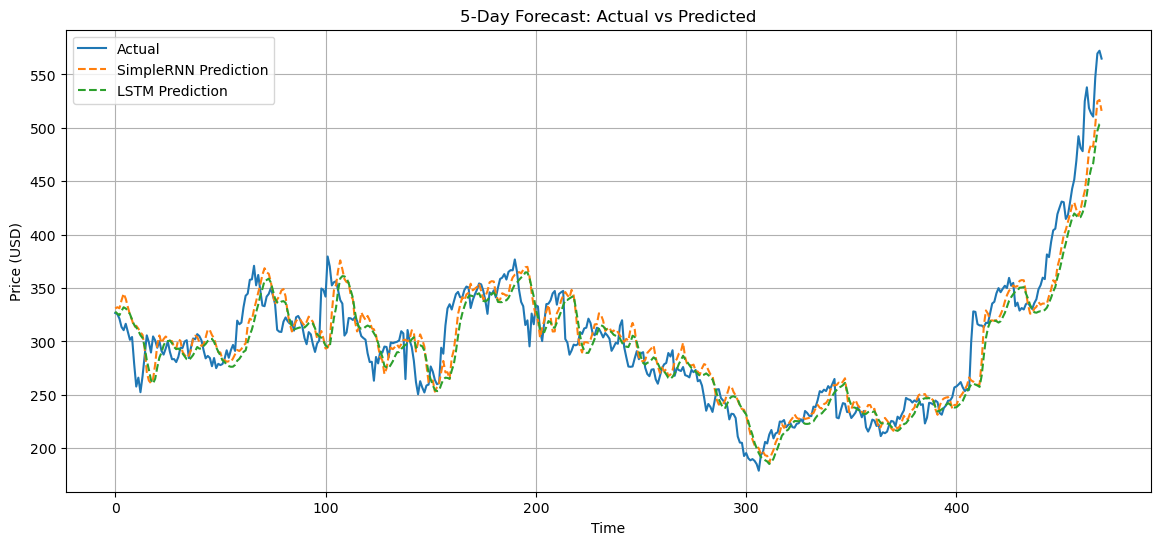

In [49]:
plt.figure(figsize=(14, 6))
plt.plot(y5_test_actual, label='Actual')
plt.plot(rnn_pred_5_actual, label='SimpleRNN Prediction', linestyle='--')
plt.plot(lstm_pred_5_actual, label='LSTM Prediction', linestyle='--')
plt.title('5-Day Forecast: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


C:\Users\Vishal\AppData\Local\Temp\ipykernel_13524\1302053514.py:10: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Vishal\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


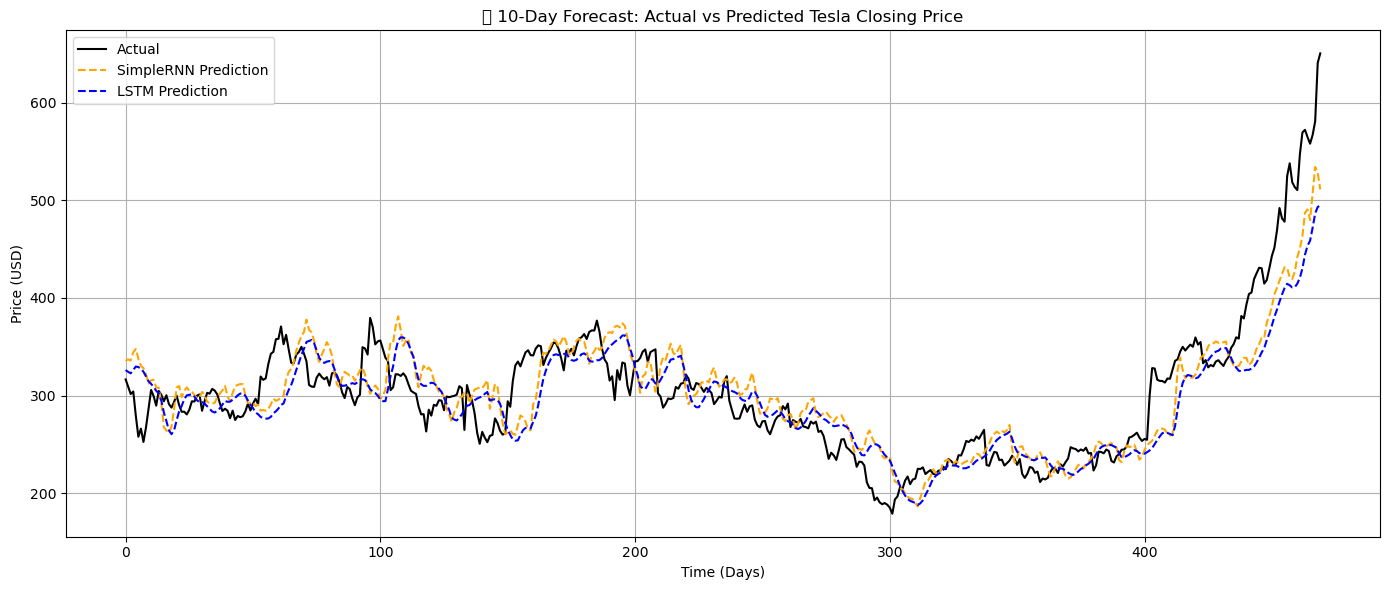

In [50]:
plt.figure(figsize=(14, 6))
plt.plot(y10_test_actual, label='Actual', color='black')
plt.plot(rnn_pred_10_actual, label='SimpleRNN Prediction', linestyle='--', color='orange')
plt.plot(lstm_pred_10_actual, label='LSTM Prediction', linestyle='--', color='blue')
plt.title('📉 10-Day Forecast: Actual vs Predicted Tesla Closing Price')
plt.xlabel('Time (Days)')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\Vishal\AppData\Local\Temp\ipykernel_13524\2510348159.py:60: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Vishal\AppData\Local\Temp\ipykernel_13524\2510348159.py:60: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Vishal\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Vishal\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


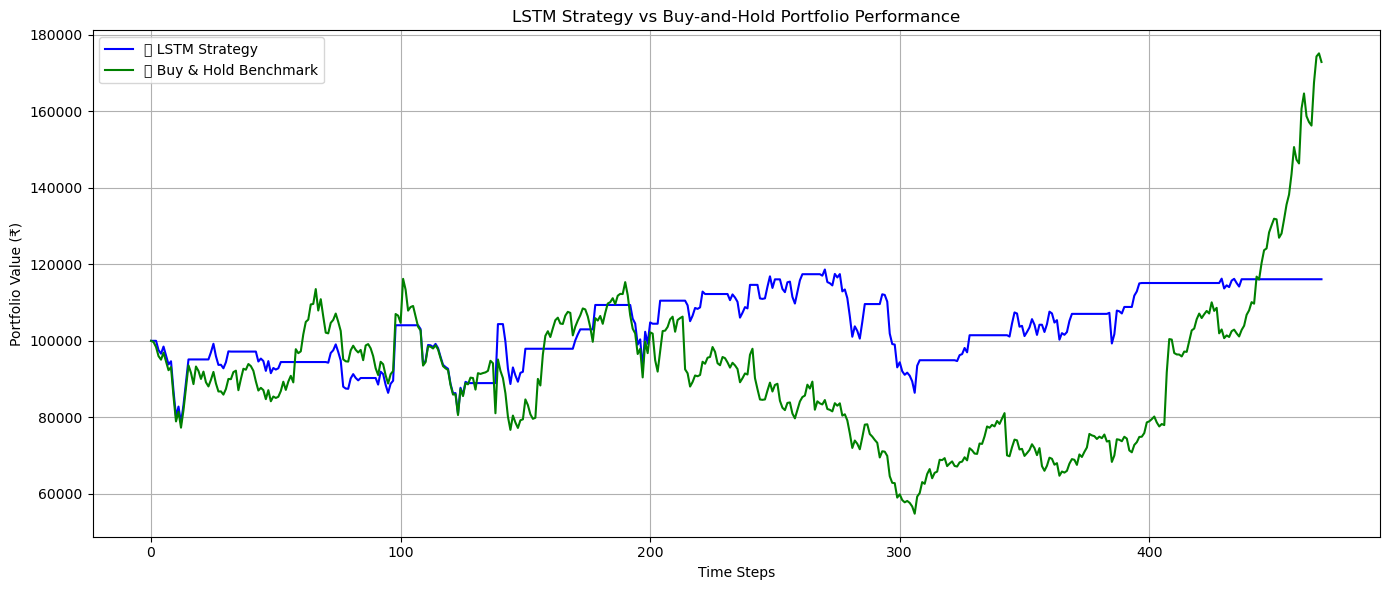

📌 Final LSTM Strategy Value: ₹116,108.00 | ROI: 16.11%
📌 Final Buy & Hold Value:    ₹172,923.49 | ROI: 72.92%


In [52]:
# Case 1
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === Step 1: Prepare DataFrame ===
# === Ensure arrays are 1D ===
actual_flat = np.ravel(y5_test_actual)       # or: y5_test_actual.flatten()
predicted_flat = np.ravel(lstm_pred_5_actual)

# === Step 1: Prepare DataFrame ===
signals = pd.DataFrame({
    'actual_price': actual_flat,
    'predicted_price': predicted_flat
})


# === Step 2: Predicted Return and Signal ===
signals['predicted_return'] = (signals['predicted_price'] - signals['actual_price']) / signals['actual_price']
signals['signal'] = np.where(signals['predicted_return'] > 0.01, 'BUY',
                     np.where(signals['predicted_return'] < -0.01, 'SELL', 'HOLD'))

# === Step 3: LSTM Strategy Portfolio Simulation ===
initial_cash = 100000
cash = initial_cash
shares = 0
strategy_value = []

for i in range(len(signals)):
    price = signals.iloc[i]['actual_price']
    action = signals.iloc[i]['signal']
    
    if action == 'BUY' and cash > 0:
        shares = cash / price
        cash = 0
    elif action == 'SELL' and shares > 0:
        cash = shares * price
        shares = 0
    # HOLD → do nothing

    total_val = cash + shares * price
    strategy_value.append(total_val)

signals['strategy_value'] = strategy_value

# === Step 4: Buy-and-Hold Benchmark ===
buy_price = signals.iloc[0]['actual_price']
shares_benchmark = initial_cash / buy_price
signals['benchmark_value'] = signals['actual_price'] * shares_benchmark

# === Step 5: Plotting Results ===
plt.figure(figsize=(14, 6))
plt.plot(signals['strategy_value'], label='📈 LSTM Strategy', color='blue')
plt.plot(signals['benchmark_value'], label='📊 Buy & Hold Benchmark', color='green')
plt.title('LSTM Strategy vs Buy-and-Hold Portfolio Performance')
plt.xlabel('Time Steps')
plt.ylabel('Portfolio Value (₹)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Step 6: Final Portfolio Summary ===
final_strategy = signals['strategy_value'].iloc[-1]
final_benchmark = signals['benchmark_value'].iloc[-1]
roi_strategy = (final_strategy - initial_cash) / initial_cash * 100
roi_benchmark = (final_benchmark - initial_cash) / initial_cash * 100

print(f"📌 Final LSTM Strategy Value: ₹{final_strategy:,.2f} | ROI: {roi_strategy:.2f}%")
print(f"📌 Final Buy & Hold Value:    ₹{final_benchmark:,.2f} | ROI: {roi_benchmark:.2f}%")


In [53]:
print(f"y5_test_actual shape: {y5_test_actual.shape}")
print(f"lstm_pred_5_actual shape: {lstm_pred_5_actual.shape}")


y5_test_actual shape: (470, 1)
lstm_pred_5_actual shape: (470, 1)


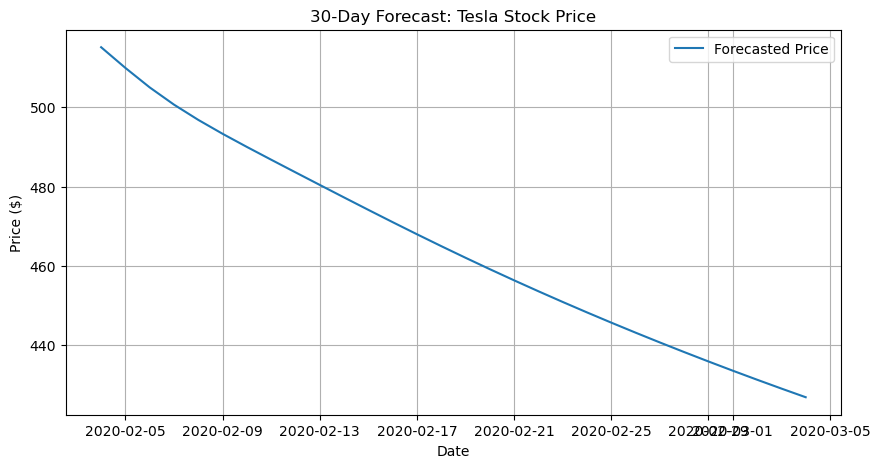

In [ ]:
# Case 2
def forecast_future_prices(model, last_sequence, days_ahead=30):
    predictions = []
    current_input = last_sequence.copy()
    
    for _ in range(days_ahead):
        pred = model.predict(current_input.reshape(1, -1, 1), verbose=0)
        predictions.append(pred[0, 0])
        current_input = np.append(current_input[1:], pred)  # slide window

    return np.array(predictions)

# Example:
last_60_days = X_test[-1].reshape(-1)  # last known 60 days
future_scaled = forecast_future_prices(lstm_model, last_60_days, days_ahead=30)
future_prices = scaler.inverse_transform(future_scaled.reshape(-1, 1))  # inverse scale

# Plot future predictions
future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=30)
plt.figure(figsize=(10,5))
plt.plot(future_dates, future_prices, label='Forecasted Price')
plt.title("30-Day Forecast: Tesla Stock Price")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.show()


In [56]:
import pandas as pd
import numpy as np

# Create mock macroeconomic data for same dates as Tesla stock
macro_dates = df.index[-300:]  # Use last 300 dates to match test data length
np.random.seed(42)

macro_df = pd.DataFrame({
    'Date': macro_dates,
    'Interest_Rate': np.random.uniform(3, 6, len(macro_dates)),  # Mock interest rate %
    'Inflation_Rate': np.random.uniform(2, 5, len(macro_dates)),  # Mock inflation %
    'EV_Index': np.linspace(1000, 1600, len(macro_dates)) + np.random.normal(0, 20, len(macro_dates))  # Simulated EV sector index
})

macro_df.to_csv('macro_indicators.csv', index=False)
print("✅ Sample macro_indicators.csv file created.")


✅ Sample macro_indicators.csv file created.


In [57]:
macro_df = pd.read_csv('macro_indicators.csv', parse_dates=['Date'])
macro_df.set_index('Date', inplace=True)

# Example columns: 'Interest_Rate', 'Inflation_Rate', 'EV_Index'


In [58]:
combined_df = df[['Close']].copy()
combined_df = combined_df.join(macro_df, how='inner')
combined_df.dropna(inplace=True)


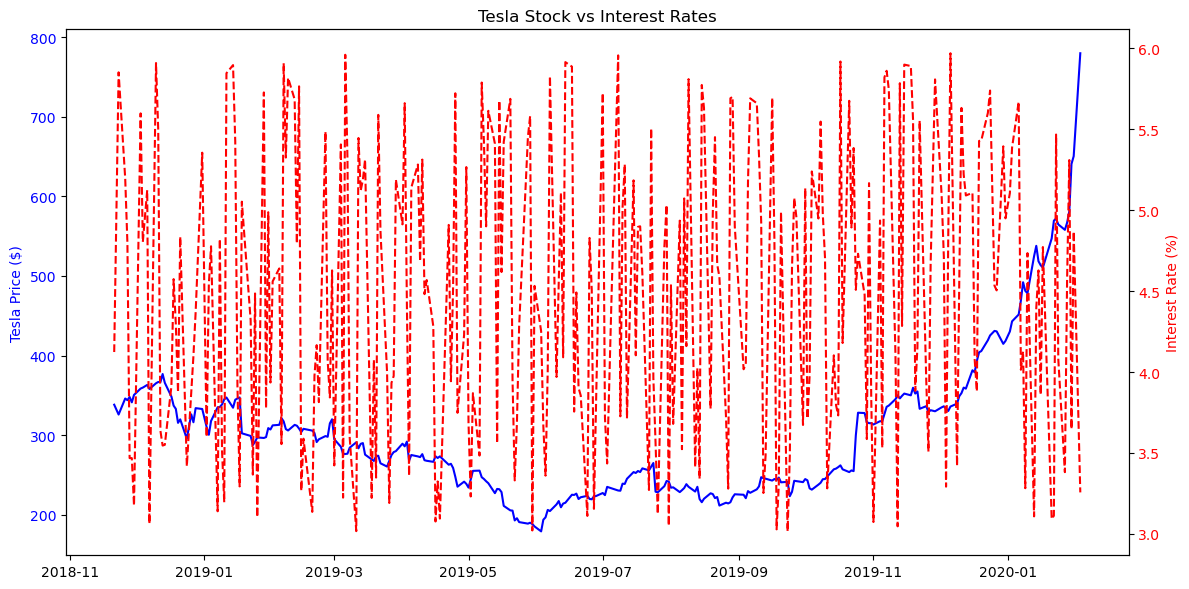

In [59]:
fig, ax1 = plt.subplots(figsize=(12,6))

# Tesla stock on primary axis
ax1.plot(combined_df.index, combined_df['Close'], 'b-', label='Tesla Close Price')
ax1.set_ylabel('Tesla Price ($)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Interest Rate on secondary axis
ax2 = ax1.twinx()
ax2.plot(combined_df.index, combined_df['Interest_Rate'], 'r--', label='Interest Rate')
ax2.set_ylabel('Interest Rate (%)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('Tesla Stock vs Interest Rates')
fig.tight_layout()
plt.show()


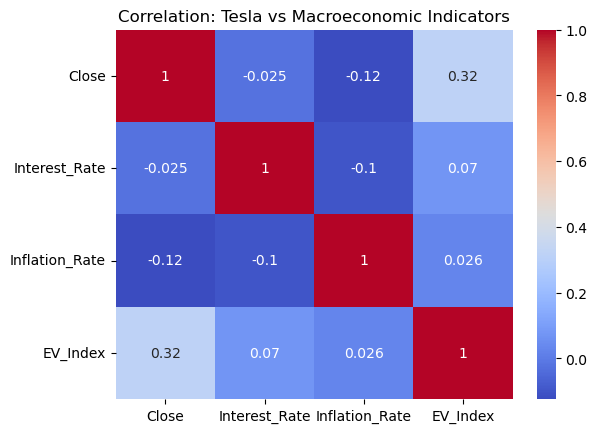

In [60]:
import seaborn as sns

corr_matrix = combined_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation: Tesla vs Macroeconomic Indicators")
plt.show()


In [2]:
import sys
import subprocess

# Install yfinance using the same Python interpreter that is running this notebook
subprocess.check_call([sys.executable, "-m", "pip", "install", "yfinance"])


0

In [3]:
import yfinance as yf
print("yfinance is working ✅")


yfinance is working ✅


In [ ]:
# Case 3
import yfinance as yf
import pandas as pd

# Fetch Tesla data
tesla = yf.Ticker("TSLA")
earnings = tesla.quarterly_earnings

# Check if earnings data is available
if earnings is not None and not earnings.empty:
    earnings_df = earnings.reset_index()
    earnings_df.columns = ['Date', 'EPS_Estimate', 'Reported_EPS', 'Surprise']
    earnings_df['Date'] = pd.to_datetime(earnings_df['Date'])
    earnings_df.sort_values('Date', inplace=True)
    print(earnings_df)
else:
    print("❌ Earnings data not available for Tesla.")


❌ Earnings data not available for Tesla.


In [9]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Step 1: Load Tesla earnings
tesla = yf.Ticker("TSLA")
earnings = tesla.quarterly_earnings

# Step 2: Check if data is available
if earnings is not None and not earnings.empty:
    earnings_df = earnings.reset_index()
    earnings_df.columns = ['Date', 'EPS_Estimate', 'Reported_EPS', 'Surprise']
    earnings_df['Date'] = pd.to_datetime(earnings_df['Date'])
    earnings_df.sort_values('Date', inplace=True)

    # Step 3: Normalize EPS
    scaler = MinMaxScaler()
    eps_scaled = scaler.fit_transform(earnings_df[['Reported_EPS']])

    # Step 4: Create EPS sequences
    def create_eps_sequences(data, seq_len=4):
        X, y = [], []
        for i in range(len(data) - seq_len):
            X.append(data[i:i+seq_len])
            y.append(data[i+seq_len])
        return np.array(X), np.array(y)

    X_eps, y_eps = create_eps_sequences(eps_scaled)
    X_eps = X_eps.reshape((X_eps.shape[0], X_eps.shape[1], 1))

    # Step 5: Define LSTM model
    model_eps = Sequential()
    model_eps.add(LSTM(50, activation='relu', input_shape=(X_eps.shape[1], 1)))
    model_eps.add(Dense(1))
    model_eps.compile(optimizer='adam', loss='mse')

    # Step 6: Train model
    model_eps.fit(X_eps, y_eps, epochs=100, verbose=0)

    # Step 7: Predict next EPS
    next_input = eps_scaled[-4:].reshape(1, 4, 1)
    next_eps_scaled = model_eps.predict(next_input, verbose=0)
    next_eps = scaler.inverse_transform(next_eps_scaled)

    print(f"🧠 Predicted Next Quarter EPS: {next_eps[0][0]:.2f}")

else:
    print("❌ Earnings data not available for Tesla.")


❌ Earnings data not available for Tesla.


c:\Users\Vishal\anaconda3\Lib\site-packages\yfinance\scrapers\fundamentals.py:36: DeprecationWarning: 'Ticker.earnings' is deprecated as not available via API. Look for "Net Income" in Ticker.income_stmt.
  warnings.warn("'Ticker.earnings' is deprecated as not available via API. Look for \"Net Income\" in Ticker.income_stmt.", DeprecationWarning)


In [10]:
tickers = ['NIO', 'RIVN', 'LCID']
data_dict = {}

for ticker in tickers:
    stock = yf.download(ticker, start='2020-01-01', end='2024-12-31')
    stock = stock[['Close']].dropna()
    data_dict[ticker] = stock


C:\Users\Vishal\AppData\Local\Temp\ipykernel_4496\1494138693.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock = yf.download(ticker, start='2020-01-01', end='2024-12-31')
[*********************100%***********************]  1 of 1 completed
C:\Users\Vishal\AppData\Local\Temp\ipykernel_4496\1494138693.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock = yf.download(ticker, start='2020-01-01', end='2024-12-31')
[*********************100%***********************]  1 of 1 completed
C:\Users\Vishal\AppData\Local\Temp\ipykernel_4496\1494138693.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock = yf.download(ticker, start='2020-01-01', end='2024-12-31')
[*********************100%***********************]  1 of 1 completed


In [11]:
def train_lstm_on_stock(df, seq_len=60):
    scaled = MinMaxScaler().fit_transform(df)
    X, y = [], []
    for i in range(len(scaled) - seq_len):
        X.append(scaled[i:i+seq_len])
        y.append(scaled[i+seq_len])
    X, y = np.array(X), np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    
    model = Sequential()
    model.add(LSTM(50, return_sequences=False, input_shape=(seq_len, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=20, verbose=0)
    
    next_input = scaled[-seq_len:].reshape(1, seq_len, 1)
    next_price_scaled = model.predict(next_input)
    next_price = MinMaxScaler().fit(df).inverse_transform(next_price_scaled)
    return next_price[0][0]

# Predict next price for each competitor
for name, df in data_dict.items():
    forecast = train_lstm_on_stock(df)
    print(f"📈 {name} → Predicted Next Price: {forecast:.2f}")


c:\Users\Vishal\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
📈 NIO → Predicted Next Price: 4.58


c:\Users\Vishal\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
📈 RIVN → Predicted Next Price: 13.28


c:\Users\Vishal\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
📈 LCID → Predicted Next Price: 2.81


In [13]:
import yfinance as yf

# Load closing prices for multiple EV stocks
tickers = ['NIO', 'RIVN', 'LCID']
data_dict = {}

for ticker in tickers:
    df = yf.download(ticker, start='2020-01-01', end='2024-12-31')['Close']
    data_dict[ticker] = df.dropna().values.reshape(-1, 1)  # ensure proper shape


C:\Users\Vishal\AppData\Local\Temp\ipykernel_4496\4067971001.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start='2020-01-01', end='2024-12-31')['Close']
[*********************100%***********************]  1 of 1 completed
C:\Users\Vishal\AppData\Local\Temp\ipykernel_4496\4067971001.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start='2020-01-01', end='2024-12-31')['Close']
[*********************100%***********************]  1 of 1 completed
C:\Users\Vishal\AppData\Local\Temp\ipykernel_4496\4067971001.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start='2020-01-01', end='2024-12-31')['Close']
[*********************100%***********************]  1 of 1 completed


In [14]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np

def train_lstm_on_stock(stock_data):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(stock_data)

    def create_sequences(data, seq_len=30):
        X, y = [], []
        for i in range(len(data) - seq_len):
            X.append(data[i:i+seq_len])
            y.append(data[i+seq_len])
        return np.array(X), np.array(y)

    X, y = create_sequences(scaled)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=10, verbose=0)  # Keep epochs small for speed

    last_input = scaled[-30:].reshape(1, 30, 1)
    pred_scaled = model.predict(last_input, verbose=0)
    pred = scaler.inverse_transform(pred_scaled)
    return float(pred[0][0])


In [16]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# --- Step 1: Mock Tesla EPS data (since yfinance.quarterly_earnings is often None) ---
eps_data = {
    'Date': pd.date_range(start='2020-01-01', periods=12, freq='Q'),
    'Reported_EPS': [0.32, 0.44, 0.76, 0.93, 1.45, 1.02, 1.07, 1.19, 1.12, 1.24, 1.09, 1.18]
}
earnings_df = pd.DataFrame(eps_data)

# Normalize
scaler_eps = MinMaxScaler()
eps_scaled = scaler_eps.fit_transform(earnings_df[['Reported_EPS']])

# Create supervised sequence
def create_sequences(data, seq_len=4):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

X_eps, y_eps = create_sequences(eps_scaled)
X_eps = X_eps.reshape((X_eps.shape[0], X_eps.shape[1], 1))

# Train LSTM
model_eps = Sequential()
model_eps.add(LSTM(50, activation='relu', input_shape=(X_eps.shape[1], 1)))
model_eps.add(Dense(1))
model_eps.compile(optimizer='adam', loss='mse')
model_eps.fit(X_eps, y_eps, epochs=100, verbose=0)

# Predict next EPS
next_input = eps_scaled[-4:].reshape(1, 4, 1)
next_eps_scaled = model_eps.predict(next_input)
next_eps = scaler_eps.inverse_transform(next_eps_scaled)
print(f"🧠 Predicted Tesla EPS: {next_eps[0][0]:.2f}")


C:\Users\Vishal\AppData\Local\Temp\ipykernel_4496\428013130.py:11: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  'Date': pd.date_range(start='2020-01-01', periods=12, freq='Q'),
c:\Users\Vishal\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
🧠 Predicted Tesla EPS: 1.21


In [17]:
tickers = ['NIO', 'RIVN', 'LCID']
data_dict = {}

# Download historical prices
for ticker in tickers:
    df = yf.download(ticker, start='2021-01-01', end='2024-12-31')['Close']
    data_dict[ticker] = df.dropna().values.reshape(-1, 1)

# LSTM training and prediction function
def train_lstm_on_stock(stock_data):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(stock_data)

    X, y = [], []
    for i in range(len(scaled) - 30):
        X.append(scaled[i:i+30])
        y.append(scaled[i+30])
    X, y = np.array(X), np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(30, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=10, verbose=0)

    last_input = scaled[-30:].reshape(1, 30, 1)
    next_scaled = model.predict(last_input, verbose=0)
    return scaler.inverse_transform(next_scaled)[0][0]


C:\Users\Vishal\AppData\Local\Temp\ipykernel_4496\3750795302.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start='2021-01-01', end='2024-12-31')['Close']
[*********************100%***********************]  1 of 1 completed
C:\Users\Vishal\AppData\Local\Temp\ipykernel_4496\3750795302.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start='2021-01-01', end='2024-12-31')['Close']
[*********************100%***********************]  1 of 1 completed
C:\Users\Vishal\AppData\Local\Temp\ipykernel_4496\3750795302.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start='2021-01-01', end='2024-12-31')['Close']
[*********************100%***********************]  1 of 1 completed


c:\Users\Vishal\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


c:\Users\Vishal\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


c:\Users\Vishal\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\Vishal\AppData\Local\Temp\ipykernel_4496\542665716.py:13: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Vishal\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


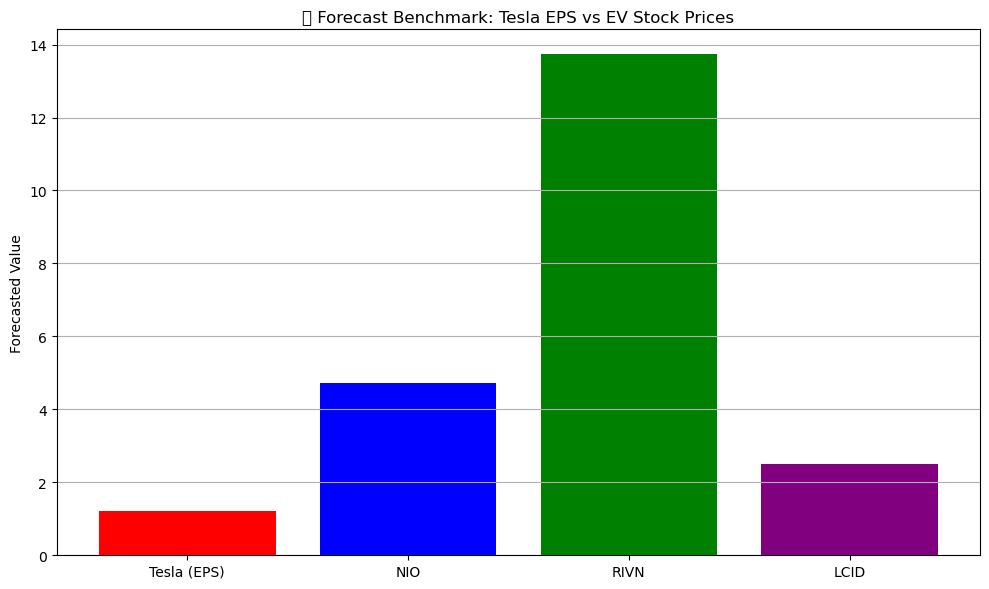

In [18]:
predictions = {
    'Tesla (EPS)': next_eps[0][0],
    'NIO': train_lstm_on_stock(data_dict['NIO']),
    'RIVN': train_lstm_on_stock(data_dict['RIVN']),
    'LCID': train_lstm_on_stock(data_dict['LCID']),
}

plt.figure(figsize=(10, 6))
plt.bar(predictions.keys(), predictions.values(), color=['red', 'blue', 'green', 'purple'])
plt.title('📊 Forecast Benchmark: Tesla EPS vs EV Stock Prices')
plt.ylabel('Forecasted Value')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [ ]:
# Case 4
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, Dropout, LayerNormalization, MultiHeadAttention, Add, GlobalAveragePooling1D

# Load Tesla data
df = pd.read_csv('TSLA.csv')  # Ensure this file exists in your working dir

# Preprocessing
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df[['Close']].dropna()

# Normalize
scaler = MinMaxScaler()
df['Close_scaled'] = scaler.fit_transform(df[['Close']])

# Sequence data
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

seq_len = 60
X, y = create_sequences(df['Close_scaled'].values, seq_len)

# Train/Test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape input to be [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))



In [15]:
def build_lstm_model(input_shape):
    inputs = Input(shape=input_shape)
    x = LSTM(64, return_sequences=True)(inputs)
    x = Dropout(0.2)(x)
    x = LSTM(32)(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1)(x)
    return Model(inputs, outputs)


In [16]:
def build_gru_model(input_shape):
    inputs = Input(shape=input_shape)
    x = GRU(64, return_sequences=True)(inputs)
    x = Dropout(0.2)(x)
    x = GRU(32)(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1)(x)
    return Model(inputs, outputs)


In [17]:
def build_transformer_model(input_shape, num_heads=4, ff_dim=64):
    inputs = Input(shape=input_shape)
    x = LayerNormalization(epsilon=1e-6)(inputs)
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=input_shape[-1])(x, x)
    x = Add()([x, attn_output])
    x = LayerNormalization(epsilon=1e-6)(x)
    x = Dense(ff_dim, activation='relu')(x)
    x = GlobalAveragePooling1D()(x)
    outputs = Dense(1)(x)
    return Model(inputs, outputs)


In [18]:
def train_and_evaluate(model_builder, name):
    model = model_builder((X_train.shape[1], X_train.shape[2]))
    model.compile(optimizer='adam', loss='mse')

    start = time.time()
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
    end = time.time()

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = sqrt(mse)

    return {'Model': name, 'MSE': mse, 'RMSE': rmse, 'Time (s)': round(end - start, 2)}


In [19]:
results = []
results.append(train_and_evaluate(build_lstm_model, 'LSTM'))
results.append(train_and_evaluate(build_gru_model, 'GRU'))
results.append(train_and_evaluate(build_transformer_model, 'Transformer'))

df_results = pd.DataFrame(results)
print(df_results)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
         Model       MSE      RMSE  Time (s)
0         LSTM  0.001198  0.034615     33.13
1          GRU  0.000780  0.027933     28.18
2  Transformer  0.042659  0.206540      7.98


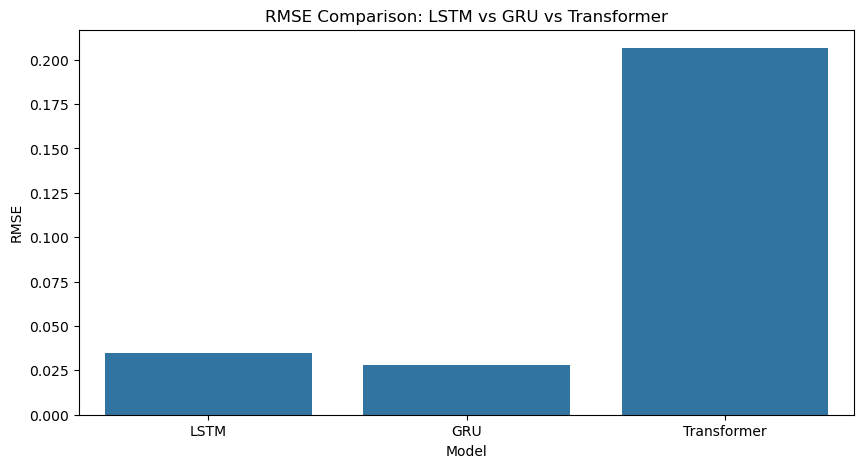

In [20]:
plt.figure(figsize=(10, 5))
sns.barplot(data=df_results, x='Model', y='RMSE')
plt.title("RMSE Comparison: LSTM vs GRU vs Transformer")
plt.ylabel("RMSE")
plt.show()


In [4]:
import pandas as pd
import ta  # technical analysis library

# Load your stock data
df = pd.read_csv('TSLA.csv')

# Ensure datetime is parsed
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Add technical indicators using ta library
df['SMA_20'] = ta.trend.sma_indicator(df['Close'], window=20)
df['EMA_20'] = ta.trend.ema_indicator(df['Close'], window=20)
df['RSI'] = ta.momentum.rsi(df['Close'], window=14)
df['MACD'] = ta.trend.macd(df['Close'])
df['BB_High'] = ta.volatility.bollinger_hband(df['Close'])
df['BB_Low'] = ta.volatility.bollinger_lband(df['Close'])

# Fill missing values
df.fillna(method='bfill', inplace=True)


C:\Users\Vishal\AppData\Local\Temp\ipykernel_15748\716144237.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


In [5]:
# Price return
df['Daily_Return'] = df['Close'].pct_change().fillna(0)

# Volume change
df['Volume_Change'] = df['Volume'].pct_change().fillna(0)

# Price volatility (rolling std)
df['Volatility'] = df['Close'].rolling(window=10).std().fillna(0)


In [2]:
!pip install newsapi-python


In [3]:
!pip install textblob


  Using cached textblob-0.19.0-py3-none-any.whl.metadata (4.4 kB)
Using cached textblob-0.19.0-py3-none-any.whl (624 kB)


In [7]:
import pandas as pd
from newsapi import NewsApiClient
from textblob import TextBlob

# Load your Tesla stock dataset
df = pd.read_csv('TSLA.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# ✅ Initialize News API
newsapi = NewsApiClient(api_key='c7fa67e759034f14aa1edf8bba87f3eb')

# ✅ Get news articles (past few days to limit to recent data)
articles = newsapi.get_everything(q='Tesla', language='en', sort_by='publishedAt', page_size=100)

# ✅ Extract sentiment scores
sentiment_scores = []
for article in articles['articles']:
    title = article.get('title') or ""
    desc = article.get('description') or ""
    text = f"{title} {desc}"
    if text.strip():
        polarity = TextBlob(text).sentiment.polarity
        sentiment_scores.append(polarity)

# ✅ Compute average sentiment score
avg_sentiment = sum(sentiment_scores) / len(sentiment_scores) if sentiment_scores else 0.0

# ✅ Add as new feature (same value repeated across recent rows)
df['News_Sentiment'] = avg_sentiment


In [9]:
import pandas as pd
import ta  # technical analysis indicators

df = pd.read_csv('TSLA.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Add indicators
df['RSI'] = ta.momentum.rsi(df['Close'], window=14)
df['MACD'] = ta.trend.macd_diff(df['Close'])  # MACD Histogram
df['SMA_20'] = ta.trend.sma_indicator(df['Close'], window=20)
df['EMA_20'] = ta.trend.ema_indicator(df['Close'], window=20)

df.dropna(inplace=True)
